In [1]:
import numpy as np
from header import *
#import density_profile as profile
#import eddington_inversion as edd
import matplotlib.pyplot as plt
import density_profile as profile
from astropy.cosmology import Planck18 as cosmo
import tde_sm16 as tde
import eddington_inversion as edd

### eddington inversion

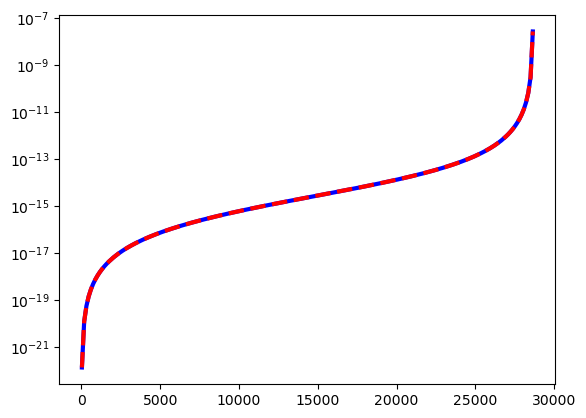

In [ ]:
# check eddington inversion
Mstar = 1e9         # Msun (total stellar mass)
Mbh   = 0          # Msun (SMBH mass)
a    = 150.0        # pc (projected half-light radius -> a = Re/1.8153)

E_grid = np.linspace(0.001, 0.999, 201) * G_pc_kms2_Msun * Mstar / a
r_grid = np.logspace(-6, 6, 300)
fE = edd.eddington_inversion_from_rho(r_grid, E_grid, profile_type="hernquist",
    profile_params={"Mstar": Mstar, "Mbh": Mbh, "a": a},
    ln_spline_smoothing=1e-8, force_zero_boundary=True)

plt.plot(E_grid, fE/Mstar, lw=3, c='b')
plt.plot(E_grid, profile.hernquist_fphase(E_grid/(G_pc_kms2_Msun * Mstar / a)) * (G_pc_kms2_Msun * Mstar * a)**(-3/2), lw=3, c='r', ls='--')
plt.yscale('log')
plt.show()

0.46869021974542435
4.311077124463256


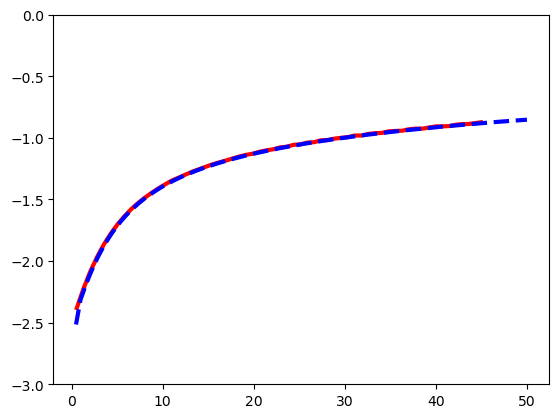

In [38]:
# check eddington inversion
Mbh   = 1e6     # Msun (SMBH mass)
sigma = 70      
rh = G_pc_kms2_Msun * Mbh / sigma**2
norm = 1/rh**3/sigma**3 * Mbh

rmax = 1.2*rh
Emin = profile.cuspy_isothermal_potential(rmax, sigma=sigma, rzero=rh) + profile.bh_potential(rmax, Mbh)
print(Emin/sigma**2)
E_grid = np.linspace(Emin, 50*sigma**2, 101)
r_grid = np.logspace(-3, np.log10(rmax), 101)
fE = edd.eddington_inversion_from_rho(r_grid, E_grid, profile_type='cuspy_isothermal', 
                                    profile_params={'Mbh': Mbh, 'sigma': sigma, 'rzero': rh},
                                    ln_spline_smoothing=1e-8, force_zero_boundary=False)

f = np.genfromtxt('Wang&Meritt04.dat')
sel = f[:,0] >= 0
plt.plot(f[sel,0], f[sel,1], lw=3, c='r')

plt.plot(E_grid/sigma**2, np.log10(fE/norm), lw=3, c='b', ls='--')
#plt.plot(E_grid, profile.hernquist_fphase(E_grid/(G_pc_kms2_Msun * Mstar / a)) * (G_pc_kms2_Msun * Mstar * a)**(-3/2), lw=3, c='r', ls='--')

print(norm)

plt.ylim(-3, 0)
#plt.yscale('log')
plt.show()

### density profile

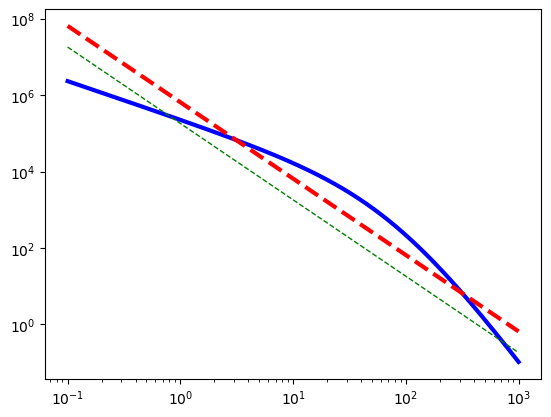

In [12]:
r_grid = np.logspace(-1, 3, 300)

plt.plot(r_grid, profile.hernquist_density(r_grid, Mstar=1e10, a=150/1.8153), lw=3, c='b')

rho = 6.5e5 * r_grid**(-2)
plt.plot(r_grid, rho, lw=3, c='r', ls='--')

rho = profile.cuspy_isothermal_density(r_grid, sigma=70)
plt.plot(r_grid, rho, lw=1, c='g', ls='--')

plt.yscale('log')
plt.xscale('log')
plt.show()


### TDE rates

In [ ]:
# Free parameters:
params = {}
params['sigma'] = 132        
params['Mbh']   = 1e6         
params['Mstar'] = 1e10         # Msun (total stellar mass)
params['Re']    = 500.0       # pc (projected half-light radius -> a = Re/1.8153)
params['a']     = params['Re']/1.8153

print(profile.total_potential(np.array([1e-4, 1e-2, 1e2, 1e4]), profile_type='cuspy_isothermal', profile_params=params))
print(profile.total_potential(np.array([1e-4, 1e-2, 1e2, 1e4]), profile_type='hernquist', profile_params=params))


[ 88983.53666248  43852.8688398  -46408.46680557 -91539.13462825]
[4.31661520e+07 5.86246437e+05 1.14602975e+05 4.18614033e+03]


In [57]:
# Free parameters:
params = {}
params['sigma'] = 70         
params['Mbh']   = 1e6   
params['rh']    = G_pc_kms2_Msun * params['Mbh'] / params['sigma']**2
params['rzero'] = params['rh']     
print(params['rh'])

out = tde.loss_cone_rate_SM16(profile_type='cuspy_isothermal', params=params,
    n_r = 300, n_E = 50,
    rmin_pc = 0.001 * params['rh'], rmax_pc = 5*params['rh'])

out/pc_per_kms_to_yr

0.8777551020408163
E [   4967.69600173    5719.66553419    6585.46211595    7582.31596259
    8730.06546001   10051.55196803   11573.0743863    13324.91252862
   15341.92972142   17664.26661875   20338.14004131   23416.76273732
   26961.40236924   31042.60080143   35741.57795353   41151.84815795
   47381.08118832   54553.24499541   62811.07279297   72318.90359107
   83265.95270636   95870.07733554  110382.11213094  127090.86106025
  146328.8448936   168478.91869853  193981.89103771  223345.29649908
  257153.49614033  296079.30685691  340897.39110926  392499.67347859
  451913.0908556   520320.02950902  599081.85575173  689766.00848826
  794177.19281253  914393.2954393  1052806.73672244 1212172.0822063
 1395660.8612277  1606924.68351317 1850167.90985486 2130231.32308406
 2452688.46447805 2823956.55279091 3251424.19330773 3743598.41845966
 4310273.98625474 4962728.30573229]
q [1.14617190e+00 1.25869541e+00 1.33153147e+00 1.44264692e+00
 1.37749466e+00 1.33947361e+00 1.30773467e+00 1.36541

1.0897851328671333

In [47]:
print((100/70)**(7/2))
2.6757837820056674/1.1670348356234448

3.4846315140944424


2.2928054076262683

In [5]:
# Free parameters:
params = {}
params['Mstar'] = 1e10         # Msun (total stellar mass)
params['Mbh']   = 1e7         # Msun (SMBH mass)
params['Re']    = 500.0       # pc (projected half-light radius -> a = Re/1.8153)

out = tde.loss_cone_rate_SM16(profile_type='hernquist', params=params,
    n_r = 400, n_E = 400,
    rmin_pc = 1e-4, rmax_pc = 1e4)

print("TDE rate [yr^-1] =", out/pc_per_kms_to_yr)

E [4.19043024e+03 4.31338851e+03 4.43995471e+03 4.57023469e+03
 4.70433743e+03 4.84237509e+03 4.98446315e+03 5.13072045e+03
 5.28126932e+03 5.43623569e+03 5.59574918e+03 5.75994322e+03
 5.92895515e+03 6.10292633e+03 6.28200228e+03 6.46633280e+03
 6.65607206e+03 6.85137877e+03 7.05241629e+03 7.25935278e+03
 7.47236134e+03 7.69162013e+03 7.91731255e+03 8.14962738e+03
 8.38875895e+03 8.63490726e+03 8.88827821e+03 9.14908374e+03
 9.41754198e+03 9.69387751e+03 9.97832144e+03 1.02711117e+04
 1.05724932e+04 1.08827180e+04 1.12020457e+04 1.15307433e+04
 1.18690857e+04 1.22173560e+04 1.25758454e+04 1.29448539e+04
 1.33246900e+04 1.37156716e+04 1.41181256e+04 1.45323886e+04
 1.49588072e+04 1.53977381e+04 1.58495483e+04 1.63146159e+04
 1.67933297e+04 1.72860903e+04 1.77933098e+04 1.83154124e+04
 1.88528349e+04 1.94060268e+04 1.99754509e+04 2.05615833e+04
 2.11649144e+04 2.17859488e+04 2.24252060e+04 2.30832206e+04
 2.37605432e+04 2.44577402e+04 2.51753948e+04 2.59141073e+04
 2.66744956e+04 2.7457

In [ ]:
for Mstar in [1e8, 1e9, 1e10, 1e11]:
    for Mbh in [1e6, 1e7, 1e8]:
        Re    = 100.0        # pc (projected half-light radius -> a = Re/1.8153)
        nLRD = 3e-5 * 2 # Mpc^-3 # integrated roughly between z = 4 and z = 6 according to the conservative estimate in Greene+25

        rate_per_gal = tde.loss_cone_rate_hernquist_SM16(Mstar, Mbh, Re,
                n_r = 200, n_E = 200, rmin_pc = 1e-4, rmax_pc = 1e3) /pc_per_kms_to_yr
        rate = nLRD * cosmo.differential_comoving_volume(5).to('Mpc3 / sr').value * (np.pi/180)**2 * 2 \
                * 1.53 * rate_per_gal
        print(np.log10(Mstar), np.log10(Mbh), rate_per_gal, rate)


8.0 6.0 3.891997757292842e-07 0.0007386087379763015
8.0 7.0 1.321077497172777e-07 0.0002507091328938445
8.0 8.0 4.697611046408233e-08 8.914950066426903e-05
9.0 6.0 1.5087262940410859e-05 0.028632041781248695


/Users/xuejianshen/Desktop/SMBH-highZ/TDE/eddington_inversion.py:45: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(integrand, 0.0, 0.5*np.pi, epsabs=1e-8, epsrel=1e-7, limit=200)


9.0 7.0 6.345922756488169e-06 0.012043054212151098
9.0 8.0 2.6032404357609945e-06 0.004940332068032154
10.0 6.0 0.000650950326315989 1.2353491162850585
10.0 7.0 0.00026534596342610886 0.5035636179543607
10.0 8.0 0.00012728527526594877 0.2415572217403895


/Users/xuejianshen/Desktop/SMBH-highZ/TDE/eddington_inversion.py:45: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(integrand, 0.0, 0.5*np.pi, epsabs=1e-8, epsrel=1e-7, limit=200)


11.0 6.0 0.025161476052809745 47.750505606440925
11.0 7.0 0.012425232099561994 23.580139487294133
11.0 8.0 0.005837626079119804 11.078427840809777


In [15]:
# Grid parameters
# Adjust these to change the resolution and range of the grid
# For faster testing, reduce n_Mstar and n_Mbh (e.g., 10x10)
Mstar_min = 1e8   # Msun
Mstar_max = 3e10  # Msun
n_Mstar = 20      # Number of points in Mstar grid

Mbh_min = 1e6     # Msun
Mbh_max = 3e8     # Msun
n_Mbh = 20       # Number of points in Mbh grid

# Other parameters
Re = 150.0         # pc (projected half-light radius)

# Computational parameters
n_r = 200         # Radial grid points
n_E = 200         # Energy grid points
rmin_pc = 1e-4    # Minimum radius in pc
rmax_pc = 1e3     # Maximum radius in pc

# Create log-spaced grids
Mstar_grid = np.logspace(np.log10(Mstar_min), np.log10(Mstar_max), n_Mstar)
Mbh_grid = np.logspace(np.log10(Mbh_min), np.log10(Mbh_max), n_Mbh)

# Create meshgrid for 2D plotting
Mstar_2d, Mbh_2d = np.meshgrid(Mstar_grid, Mbh_grid)

# Initialize arrays to store results
rate_grid = np.zeros((n_Mbh, n_Mstar))
valid_mask = np.ones((n_Mbh, n_Mstar), dtype=bool)

print("Computing TDE rates on grid...")
print(f"Grid size: {n_Mbh} x {n_Mstar} = {n_Mbh * n_Mstar} points")

# Compute TDE rate for each combination
for i, Mbh in enumerate(Mbh_grid):
    for j, Mstar in enumerate(Mstar_grid):
        try:
            # Compute TDE rate in internal units [pc/(km/s)]
            rate_internal = tde.loss_cone_rate_hernquist_SM16(
                Mstar, Mbh, Re,
                n_r=n_r, n_E=n_E,
                rmin_pc=rmin_pc, rmax_pc=rmax_pc
            )
            
            conversion_factor = 1.53  
            rate_yr = conversion_factor * rate_internal / pc_per_kms_to_yr
            
            rate_grid[i, j] = rate_yr
            
            if j == 0:
                print(f"  Progress: Mbh={Mbh:.2e} Msun ({i+1}/{n_Mbh})")
                
        except Exception as e:
            print(f"  Warning: Failed at Mstar={Mstar:.2e}, Mbh={Mbh:.2e}: {e}")
            rate_grid[i, j] = np.nan
            valid_mask[i, j] = False

print("Computations complete!")

# Handle zero or negative rates (set to small positive value for log plot)
rate_plot = np.where(rate_grid > 0, rate_grid, 1e-10)
rate_plot = np.where(valid_mask, rate_plot, np.nan)

Computing TDE rates on grid...
Grid size: 20 x 20 = 400 points
  Progress: Mbh=1.00e+06 Msun (1/20)


/Users/xuejianshen/Desktop/SMBH-highZ/TDE/eddington_inversion.py:189: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(integrand, 0.0, 0.5*np.pi, epsabs=1e-8, epsrel=1e-7, limit=200)


  Progress: Mbh=1.35e+06 Msun (2/20)
  Progress: Mbh=1.82e+06 Msun (3/20)
  Progress: Mbh=2.46e+06 Msun (4/20)
  Progress: Mbh=3.32e+06 Msun (5/20)
  Progress: Mbh=4.49e+06 Msun (6/20)
  Progress: Mbh=6.06e+06 Msun (7/20)
  Progress: Mbh=8.18e+06 Msun (8/20)
  Progress: Mbh=1.10e+07 Msun (9/20)
  Progress: Mbh=1.49e+07 Msun (10/20)
  Progress: Mbh=2.01e+07 Msun (11/20)
  Progress: Mbh=2.72e+07 Msun (12/20)
  Progress: Mbh=3.67e+07 Msun (13/20)
  Progress: Mbh=4.95e+07 Msun (14/20)
  Progress: Mbh=6.69e+07 Msun (15/20)
  Progress: Mbh=9.03e+07 Msun (16/20)
  Progress: Mbh=1.22e+08 Msun (17/20)
  Progress: Mbh=1.65e+08 Msun (18/20)
  Progress: Mbh=2.22e+08 Msun (19/20)
  Progress: Mbh=3.00e+08 Msun (20/20)
Computations complete!


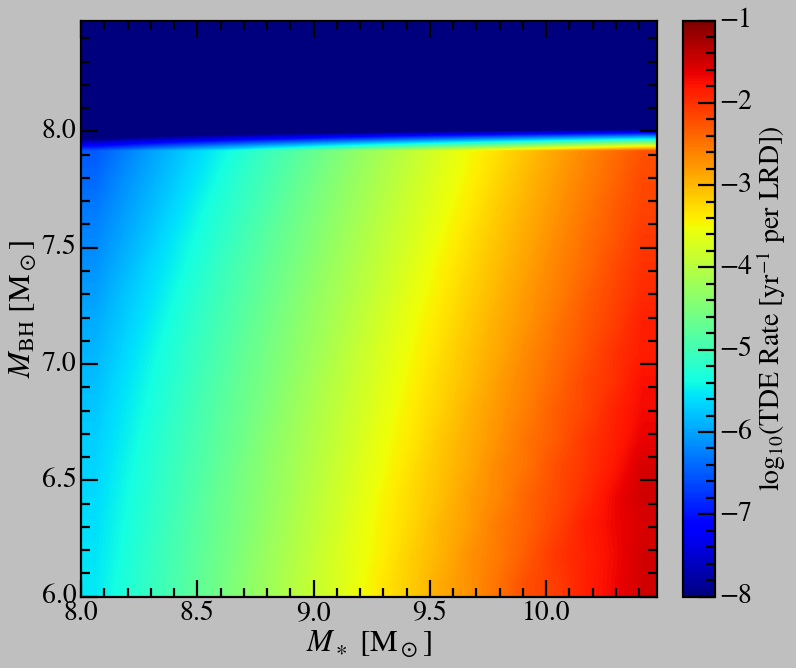

In [16]:
import matplotlib as mpl
# define matplotlib style
mpl.style.use('classic')
mpl.rc('xtick', labelsize=25); mpl.rc('ytick', labelsize=25)
mpl.rc('xtick.major', size=15 , width=2)
mpl.rc('xtick.minor', size=8, width=2, visible=True)
mpl.rc('ytick.major', size=15 , width=2)
mpl.rc('ytick.minor', size=8, width=2, visible=True)
mpl.rc('lines',linewidth=2, markersize=20)
mpl.rc('axes', linewidth=2, labelsize=28, labelpad=2.5)
mpl.rc('legend', fontsize=28, loc='best', frameon=False, numpoints=1)
mpl.rc('font', family='STIXGeneral')
mpl.rc('mathtext', fontset='stix')

# Create the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.0, 0.0, 0.9, 0.9])
cax = fig.add_axes([0.94, 0.0, 0.05, 0.9])

# Create colormesh plot
log_rate = np.log10(rate_plot)
extent = [np.log10(Mstar_grid[0]), np.log10(Mstar_grid[-1]), np.log10(Mbh_grid[0]), np.log10(Mbh_grid[-1])]
# Create imshow plot
im = ax.imshow(
    log_rate,
    extent=extent,
    cmap='jet',
    origin='lower',  # 'lower' puts first row at bottom
    interpolation='bilinear',
    vmin=-8,
    vmax=-1
)

# Labels and title
ax.set_xlabel(r'$M_\ast$ [M$_\odot$]')
ax.set_ylabel(r'$M_{\rm BH}$ [M$_\odot$]')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, cax=cax)
cbar.set_label(r'log$_{10}$(TDE Rate [yr$^{-1}$ per LRD])', fontsize=25)

plt.show()